<a href="https://www.kaggle.com/code/siriasannino/analyzing-tradeoffs?scriptVersionId=161333530" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install Independences

In [1]:
!pip install visualkeras 
!pip install keras-rectified-adam
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8254 sha256=dd42fdbed57c10301354950e489e0aa5b405bda265d68ae4c1f7e5120bfd3539
  Stored in directory: /root/.cache/pip/wheels/24/fe/0f/dcf898210ceef6ae45cea51d3d27765f38bce2b4dc8e88245f
Successfully built keras-rectified-adam
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [2]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LeakyReLU, PReLU
from keras.backend import clear_session, reset_uids
from keras import backend as K
from keras_radam import RAdam
import tensorflow_addons as tfa

# FOR TRAINING 
from keras.utils import plot_model
import visualkeras


2024-02-01 17:44:32.781932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 17:44:32.782052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 17:44:32.913748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [3]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [4]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Processing Data: Splitting 

# DataLoader

In [5]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

In [6]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt],
                                      epochs = num_epochs)

    return history, filepath, es

In [7]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))
    
    print("Train F1-Score = %.4f" % (metrics_train[2]))
    print("Train Precision = %.4f" % (metrics_train[3]))
    print("Train Recall = %.4f" % (metrics_train[4]))
    
    print("Test F1-Score = %.4f" % (metrics_val[2]))
    print("Test Precision = %.4f" % (metrics_val[3]))
    print("Test Recall = %.4f" % (metrics_val[4]))

## Accuracy and Loss Functions

In [8]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define F1 Function
def F1_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['f1_m'], color='teal', label='F1_score')
    plt.plot(hist.history['val_f1_m'], color='orange', label='val_F1_score')
    fig.suptitle('F1 Score', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Precision Function
def precision_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['precision_m'], color='teal', label='precision_score')
    plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_score')
    fig.suptitle('Precision', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Recall Function
def recall_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['recall_m'], color='teal', label='recall_score')
    plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_score')
    fig.suptitle('Recall', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    F1_function(hist)
    precision_function(hist)
    recall_function(hist)

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Make Prediction

In [10]:
def testing(model,
            train_set, 
            scale,
            test_file):
    
    # Dict with key: Number 
    #           value: Pokemon 
    diz={v:k for k,v in train_set.class_indices.items()}
   

    # Read file
    test_img = cv2.imread(test_file)
    # Resize the image testing with the input shape of neural network
    test_img = cv2.resize(test_img, scale)
    # 
    test_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)

    #test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img = test_img/255
    #plt.imshow(test_img)

    if type(model) == str:
        model = load_model(model)
        prediction_prob = model.predict(test_img)
    else:
        prediction_prob = model.predict(test_img)
    classes_x=np.argmax(prediction_prob,axis=1)
    plt.title(diz[classes_x[0]])
    return diz[classes_x[0]]

# Models

## Model 1

Image with 64 x 64 x 3 

In [11]:
#%% ----- MODEL 1 -----
#defining model
def model_1(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier


## Model 2

In [12]:
#%% ----- MODEL 2 -----
#Defining model
def model_2(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = tfa.optimizers.RectifiedAdam(lr=1e-3), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

## Model 3

In [13]:
#%% ----- MODEL 3 -----
#defining model
def model_3(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(LeakyReLU(alpha=0.3))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(LeakyReLU(alpha=0.3))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

# Training

## Training Model 1

In [14]:
train_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/train'
test_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/validation'

In [15]:
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

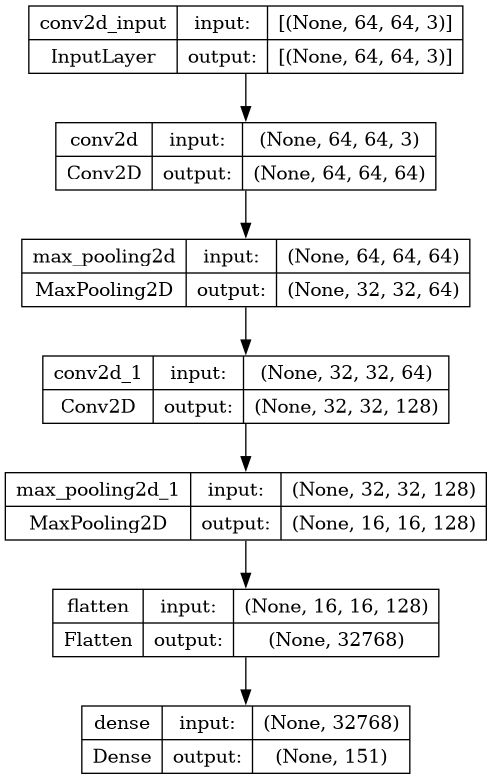

In [16]:
neuralnetwork_cnn = model_1(img_size1, num_classes= 151)
neuralnetwork_cnn.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

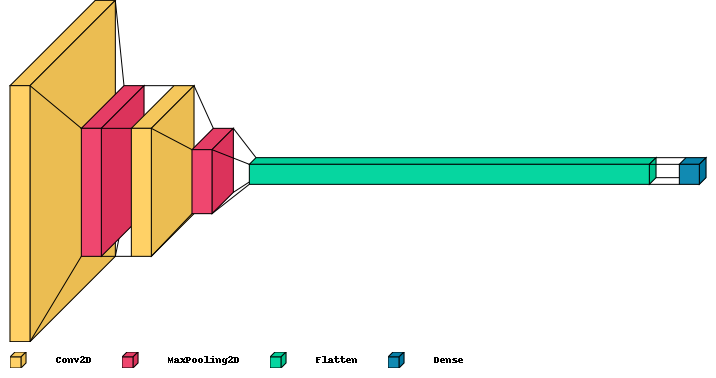

In [17]:
visualkeras.layered_view(neuralnetwork_cnn, legend = True, spacing = 30)

In [18]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [19]:
hist1 , fil1, es1 = train_model(model=neuralnetwork_cnn, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=1, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_26/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30


I0000 00:00:1706809491.913105      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 4.3901 - acc: 0.1079 - f1_m: 0.0359 - precision_m: 0.2490 - recall_m: 0.0200
Epoch 1: loss improved from inf to 4.39005, saving model to model1.h5
219/219 [==============================] - 100s 438ms/step - loss: 4.3901 - acc: 0.1079 - f1_m: 0.0359 - precision_m: 0.2490 - recall_m: 0.0200 - val_loss: 3.1377 - val_acc: 0.2849 - val_f1_m: 0.1367 - val_precision_m: 0.6608 - val_recall_m: 0.0777
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.9466 - acc: 0.3302 - f1_m: 0.2435 - precision_m: 0.6047 - recall_m: 0.1567
Epoch 2: loss improved from 4.39005 to 2.94659, saving model to model1.h5
219/219 [==============================] - 45s 207ms/step - loss: 2.9466 - acc: 0.3302 - f1_m: 0.2435 - precision_m: 0.6047 - recall_m: 0.1567 - val_loss: 2.3538 - val_acc: 0.4588 - val_f1_m: 0.3953 - val_precision_m: 0.6978 - val_recall_m: 0.2792
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 2.4272 - acc: 0.4578 - f1_m: 0.4447 - precision_m: 0.6733 - recall_m: 0.3358
Epoch 3: loss improved from 2.94659 to 2.42719, saving model to model1.h5
219/219 [==============================] - 46s 208ms/step - loss: 2.4272 - acc: 0.4578 - f1_m: 0.4447 - precision_m: 0.6733 - recall_m: 0.3358 - val_loss: 2.0010 - val_acc: 0.5408 - val_f1_m: 0.5054 - val_precision_m: 0.7380 - val_recall_m: 0.3877
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 2.2

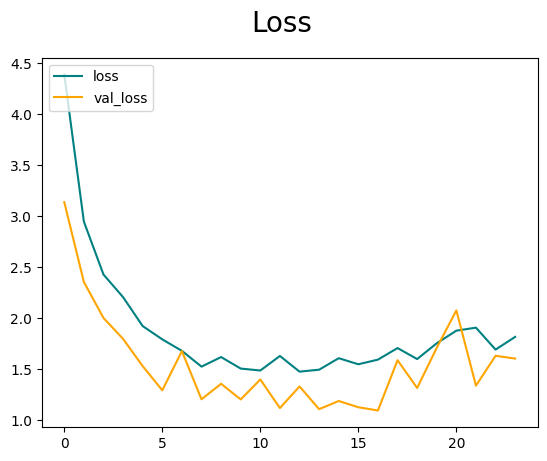

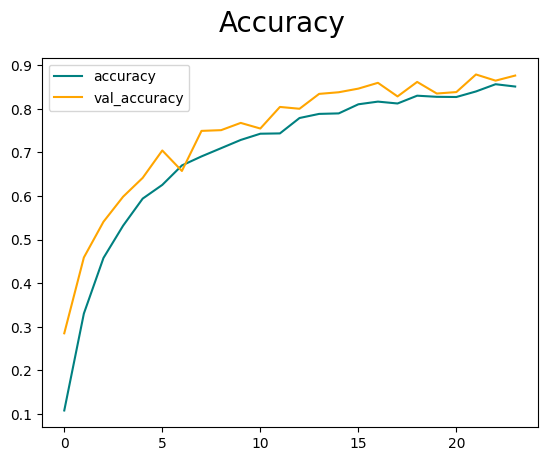

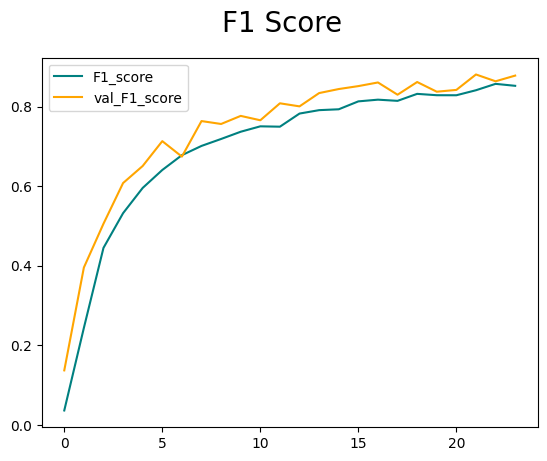

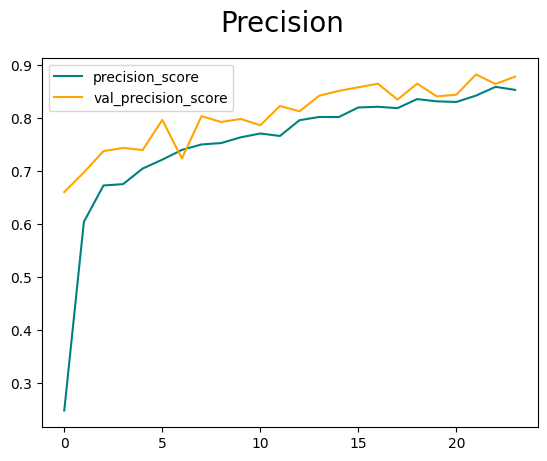

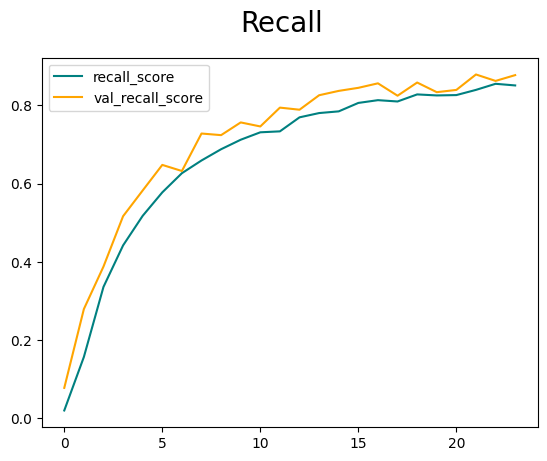

In [20]:
plot_history(hist=hist1)

## Training Model 2

In [21]:
img_size2 = (64, 64, 3)
batch_siz2 = 32
num_classes = 151

In [22]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


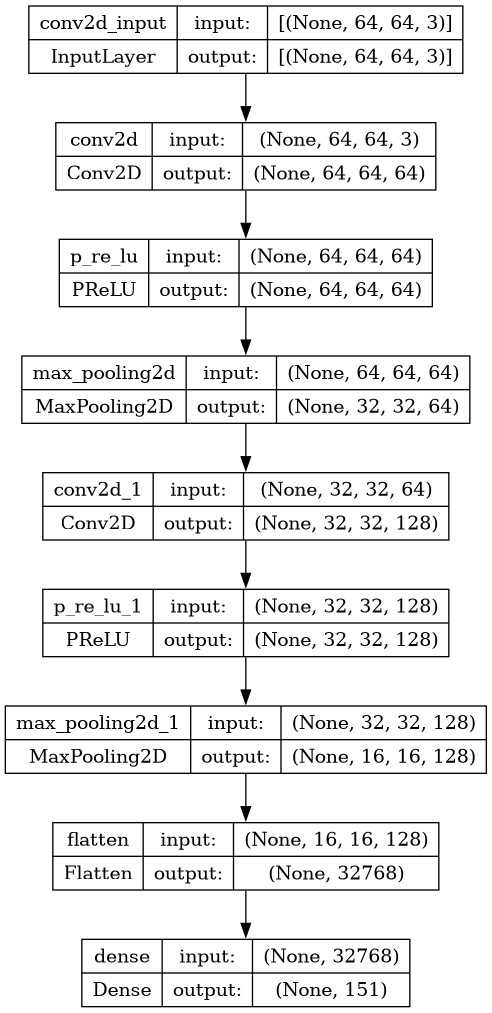

In [23]:
neuralnetwork_cnn2 = model_2(img_size2, num_classes= 151)
neuralnetwork_cnn2.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn2, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [24]:
hist2 , fil2, es2 = train_model(model=neuralnetwork_cnn2, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=2, 
                                num_epochs=30)

/tmp/ipykernel_26/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 4.2770 - acc: 0.1041 - f1_m: 0.0169 - precision_m: 0.1469 - recall_m: 0.0091
Epoch 1: loss improved from inf to 4.27704, saving model to model2.h5
219/219 [==============================] - 48s 205ms/step - loss: 4.2770 - acc: 0.1041 - f1_m: 0.0169 - precision_m: 0.1469 - recall_m: 0.0091 - val_loss: 3.0779 - val_acc: 0.3037 - val_f1_m: 0.0935 - val_precision_m: 0.6958 - val_recall_m: 0.0510
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.6609 - acc: 0.3734 - f1_m: 0.2374 - precision_m: 0.7751 - recall_m: 0.1446
Epoch 2: loss improved from 4.27704 to 2.66086, saving model to model2.h5
219/219 [==============================] - 45s 207ms/step - loss: 2.6609 - acc: 0.3734 - f1_m: 0.2374 - precision_m: 0.7751 - recall_m: 0.1446 - val_loss: 2.0508 - val_acc: 0.5150 - val_f1_m: 0.3587 - val_precision_m: 0.8419 - val_recall_m: 0.2323
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 1.9309 - acc: 0.5202 - f1_m: 0.4548 - precision_m: 0.8134 - recall_m: 0.3209
Epoch 3: loss improved from 2.66086 to 1.93089, saving model to model2.h5
219/219 [==============================] - 44s 202ms/step - loss: 1.9309 - acc: 0.5202 - f1_m: 0.4548 - precision_m: 0.8134 - recall_m: 0.3209 - val_loss: 1.5270 - val_acc: 0.6206 - val_f1_m: 0.5466 - val_precision_m: 0.8809 - val_recall_m: 0.4005
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 1.5

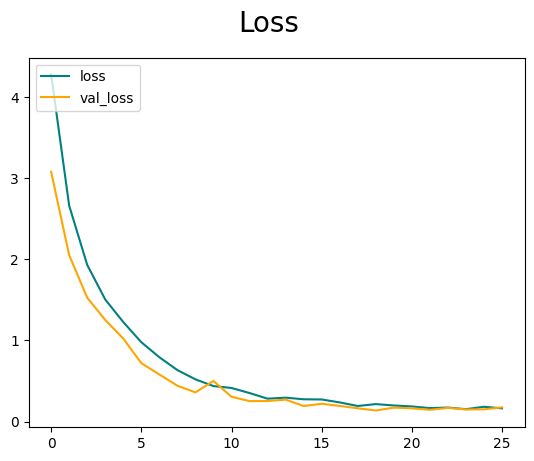

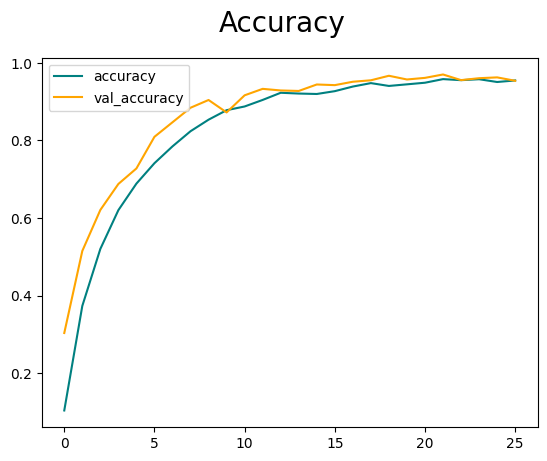

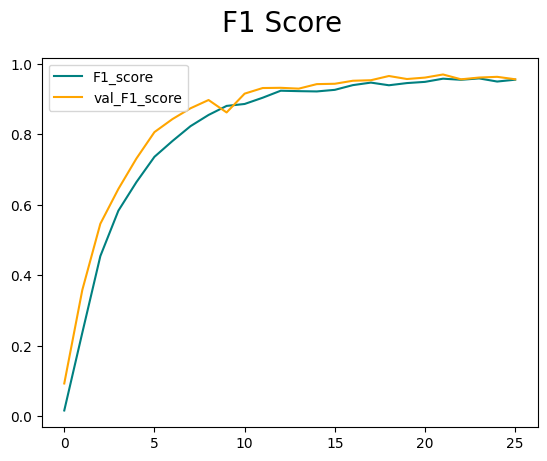

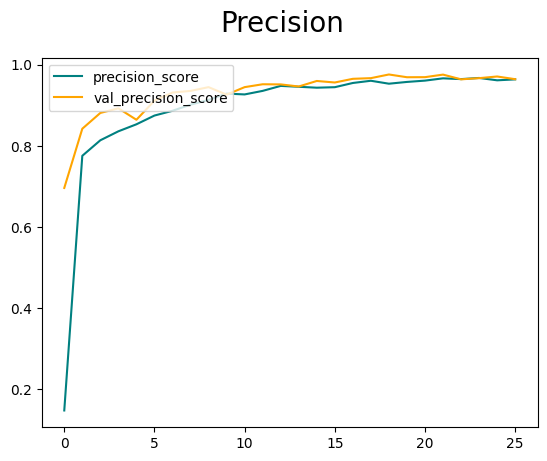

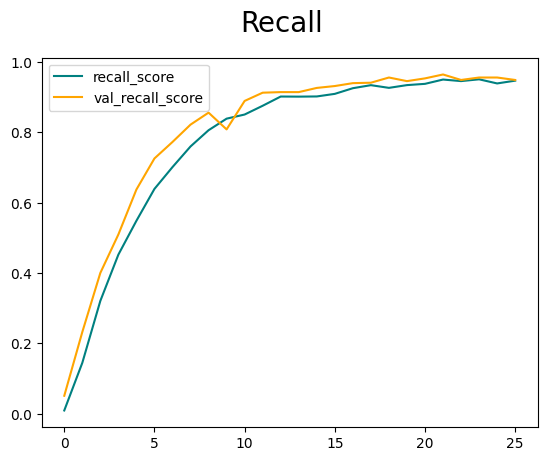

In [25]:
plot_history(hist=hist2)

## Training Model 3

In [26]:
img_size3= (64, 64, 3)
batch_siz3 = 32
num_classes = 151

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

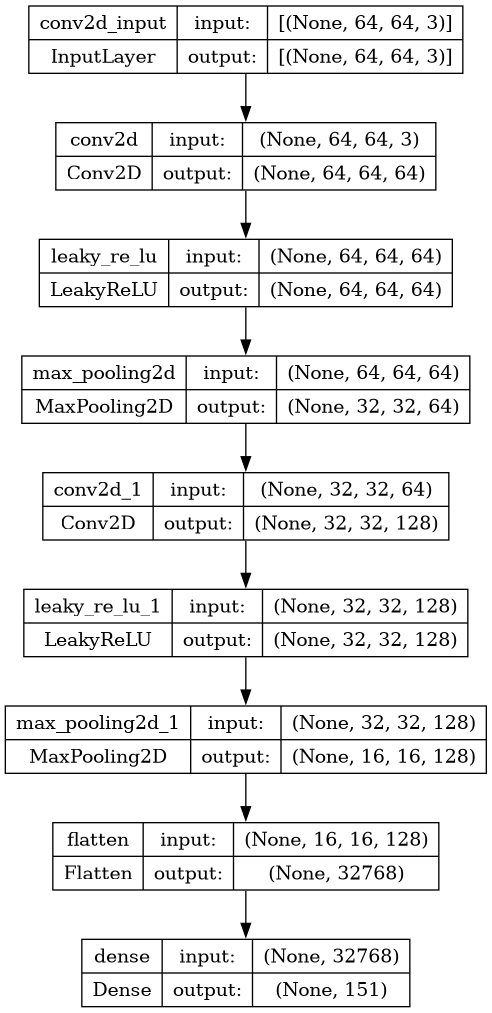

In [27]:
neuralnetwork_cnn3 = model_3(img_size3, num_classes= 151)
neuralnetwork_cnn3.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn3, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [28]:
train_set3 , val_set3 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size3,
                                  num_batch= batch_siz3)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [29]:
hist3 , fil3, es3 = train_model(model=neuralnetwork_cnn3, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=3, 
                                num_epochs= 30) # meglio che arrivi a 30

/tmp/ipykernel_26/281923535.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 3.9091 - acc: 0.1706 - f1_m: 0.0742 - precision_m: 0.3677 - recall_m: 0.0428
Epoch 1: loss improved from inf to 3.90914, saving model to model3.h5
219/219 [==============================] - 46s 204ms/step - loss: 3.9091 - acc: 0.1706 - f1_m: 0.0742 - precision_m: 0.3677 - recall_m: 0.0428 - val_loss: 2.6025 - val_acc: 0.3956 - val_f1_m: 0.2863 - val_precision_m: 0.8254 - val_recall_m: 0.1768
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.5438 - acc: 0.4061 - f1_m: 0.3296 - precision_m: 0.7224 - recall_m: 0.2180
Epoch 2: loss improved from 3.90914 to 2.54376, saving model to model3.h5
219/219 [==============================] - 45s 204ms/step - loss: 2.5438 - acc: 0.4061 - f1_m: 0.3296 - precision_m: 0.7224 - recall_m: 0.2180 - val_loss: 2.0255 - val_acc: 0.5150 - val_f1_m: 0.4550 - val_precision_m: 0.8149 - val_recall_m: 0.3203
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 1.8885 - acc: 0.5445 - f1_m: 0.5074 - precision_m: 0.7940 - recall_m: 0.3776
Epoch 3: loss improved from 2.54376 to 1.88847, saving model to model3.h5
219/219 [==============================] - 44s 202ms/step - loss: 1.8885 - acc: 0.5445 - f1_m: 0.5074 - precision_m: 0.7940 - recall_m: 0.3776 - val_loss: 1.4003 - val_acc: 0.6622 - val_f1_m: 0.6383 - val_precision_m: 0.8668 - val_recall_m: 0.5090
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 1.4

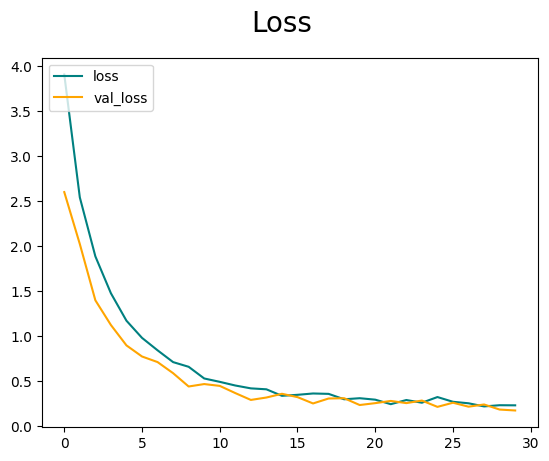

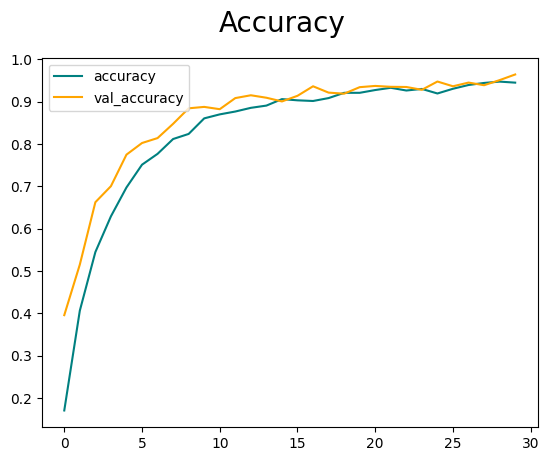

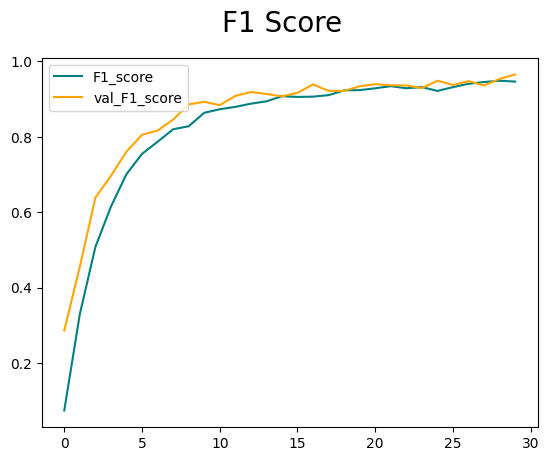

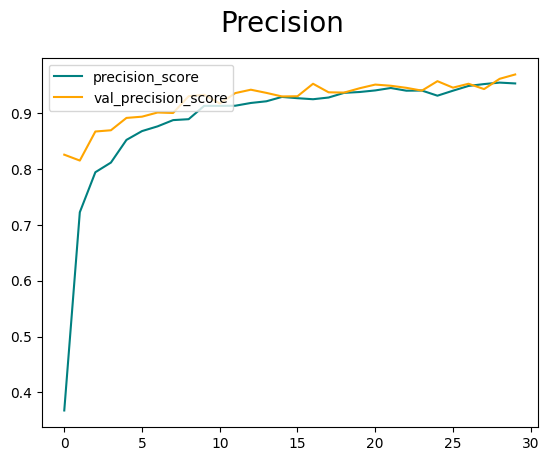

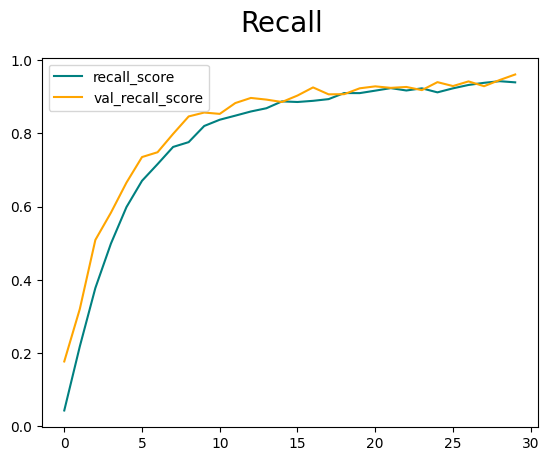

In [30]:
plot_history(hist=hist3)